In [142]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [143]:
df = pd.read_csv('online_retail.csv')
print(df.head())
print(df.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

       InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 8:26       2.55     17850.0  United Kingdom  
1  01-12-2010 8:26       3.39     17850.0  United Kingdom  
2  01-12-2010 8:26       2.75     17850.0  United Kingdom  
3  01-12-2010 8:26       3.39     17850.0  United Kingdom  
4  01-12-2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoic

## Q6

In [213]:
cleaned_data = df.dropna()

cleaned_data['InvoiceDate'] = pd.to_datetime(cleaned_data['InvoiceDate'], errors='coerce')

start_date = '2011-06-01'
end_date = '2011-11-30'

filtered_data = cleaned_data[(cleaned_data['InvoiceDate'] >= start_date) & (cleaned_data['InvoiceDate'] <= end_date)]
print(filtered_data)

       InvoiceNo StockCode                          Description  Quantity  \
45408     540258     20914  SET/5 RED RETROSPOT LID GLASS BOWLS        96   
45409     540258     37449   CERAMIC CAKE STAND + HANGING CAKES        36   
45410     540258     21156            RETROSPOT CHILDRENS APRON        80   
45411     540259     10135         COLOURING PENCILS BROWN TUBE        40   
45412     540259     21876                        POTTERING MUG        36   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899          CHILDREN'S APRON DOLLY GIRL         6   
541906    581587     23254         CHILDRENS CUTLERY DOLLY GIRL         4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138         BAKING SET 9 PIECE RETROSPOT         3   

               InvoiceDate  UnitPrice  CustomerID         Country  
45408  

C:\Users\Sameer Kaushik\AppData\Local\Temp\ipykernel_20784\1440034439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['InvoiceDate'] = pd.to_datetime(cleaned_data['InvoiceDate'], errors='coerce')


## Q7

In [ ]:
data_filtered = cleaned_data[(cleaned_data['InvoiceDate'] >= start_date) & (cleaned_data['InvoiceDate'] <= end_date)]

reference_date = datetime(2011, 11, 30)


data_filtered['Recency'] = data_filtered.groupby('CustomerID')['InvoiceDate'].transform(
    lambda x: (reference_date - x.max()).days // 30
)



In [148]:
frequency_df = data_filtered.groupby('CustomerID')['InvoiceDate'].nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

In [149]:
monetary_df = data_filtered.groupby('CustomerID')['Quantity'].sum().reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']


rfm_df = data_filtered[['CustomerID', 'Recency']].drop_duplicates().merge(
    frequency_df, on='CustomerID').merge(
    monetary_df, on='CustomerID'
)


print(rfm_df.head(10))

   CustomerID  Recency  Frequency  Monetary
0     14045.0        6          2       359
1     18226.0        0          4      1442
2     13097.0        2          3       720
3     13089.0        0         22      4239
4     18062.0        6          1       184
5     17949.0        0         10      5304
6     15271.0        3          3       155
7     12415.0        1          2      4758
8     13458.0        0          7      1873
9     14135.0        0          6      1708


## Q8

In [151]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

In [152]:
linked = linkage(rfm_scaled, method='ward')


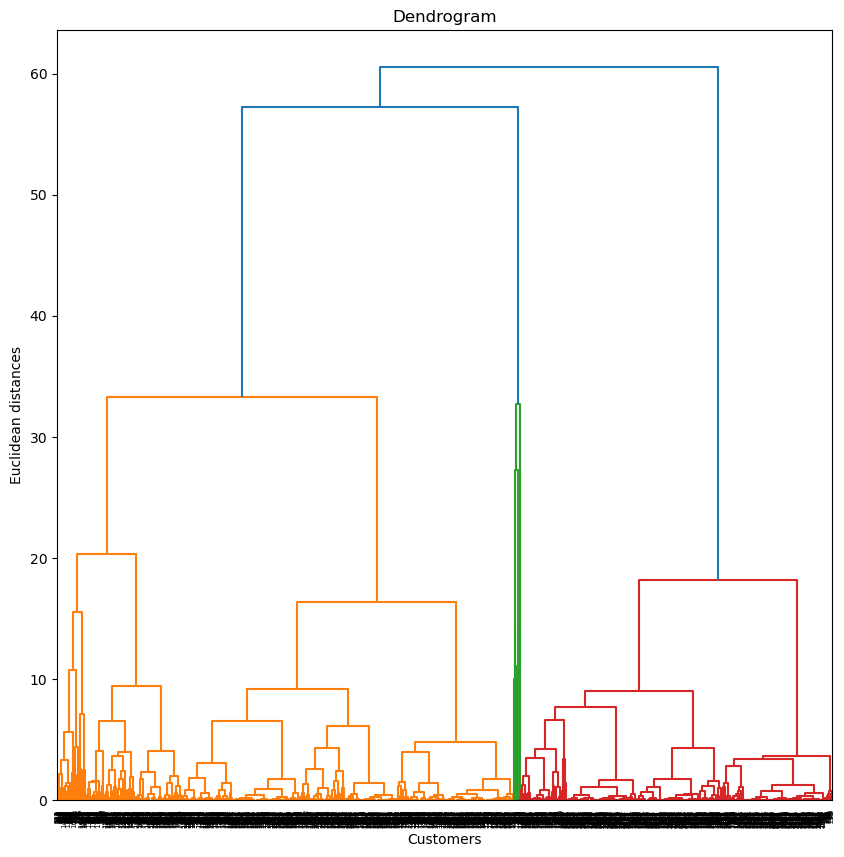

In [211]:
plt.figure(figsize=(10, 10))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [154]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

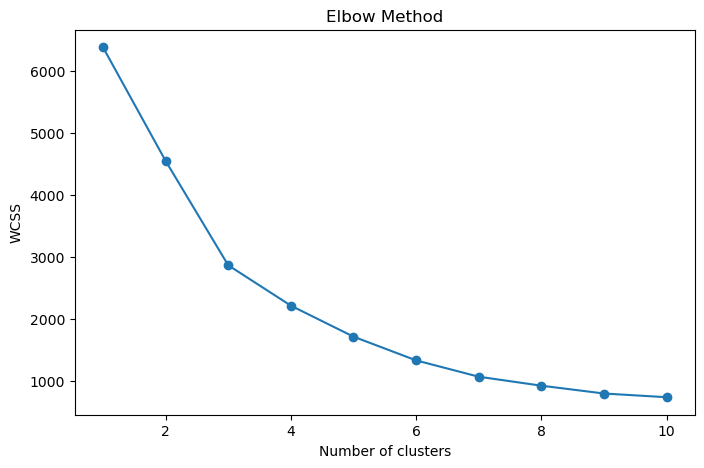

In [155]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Q9


In [198]:
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
rfm_df['Segment'] = kmeans.fit_predict(rfm_scaled)

In [200]:
segment_analysis = rfm_df.groupby('Segment').mean()

In [202]:
print("Segment Analysis:")
print(segment_analysis)
print("\nCustomer Segments with Labels:")
print(rfm_df[['CustomerID', 'Segment', 'Recency', 'Frequency', 'Monetary']])


Segment Analysis:
           CustomerID   Recency  Frequency      Monetary
Segment                                                 
0        15197.181673  0.795219   2.467729    477.517928
1        15269.294393  4.025701   1.343458    238.554907
2        15027.777778  0.444444  19.722222  10413.277778

Customer Segments with Labels:
      CustomerID  Segment  Recency  Frequency  Monetary
0        14045.0        1        6          2       359
1        18226.0        0        0          4      1442
2        13097.0        0        2          3       720
3        13089.0        2        0         22      4239
4        18062.0        1        6          1       184
...          ...      ...      ...        ...       ...
2124     13077.0        1        3          1       256
2125     16446.0        0        2          2         0
2126     17754.0        0        2          1       405
2127     14422.0        0        2          1       179
2128     12713.0        0        2          1    

## Q10

In [205]:
print("Standardized Cluster Centers:")
print(kmeans.cluster_centers_)

Standardized Cluster Centers:
[[-0.72006933  0.1140225   0.01040143]
 [ 1.07920544 -0.30423968 -0.17112554]
 [-0.917461    6.47191151  7.39258989]]


In [207]:
original_centers = scaler.inverse_transform(kmeans.cluster_centers_)

In [209]:
print("\nCluster Centers in Original RFM Scale:")
for i, center in enumerate(original_centers):
    print(f"Segment {i}: Recency = {center[0]:.2f}, Frequency = {center[1]:.2f}, Monetary = {center[2]:.2f}")



Cluster Centers in Original RFM Scale:
Segment 0: Recency = 0.80, Frequency = 2.47, Monetary = 479.44
Segment 1: Recency = 4.03, Frequency = 1.34, Monetary = 235.17
Segment 2: Recency = 0.44, Frequency = 19.72, Monetary = 10413.28
